In [26]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr


import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging,
                            cmap_negref
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'

### Load Data

a. GDP data

In [27]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_2100_df = gdp_df.loc[gdp_df.year == 2100]

b. GMT data

In [28]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

c. Regression results

In [29]:
thrshld_str = 135
thrshld = 1.35
regression_df = pd.read_csv(cset.path_CHAR_results / f'regression_data_thsld_{thrshld_str}.csv', index_col = 0)
marginal_effects_all = pd.read_csv(cset.path_CHAR_results / f'marginal_effects_EXC_all_countries_thsld_{thrshld_str}.csv', index_col = 0)
marginal_effects_focus = pd.read_csv(cset.path_CHAR_results /  f'marginal_effects_EXC_focus-countries_thsld_{thrshld_str}.csv', index_col = 0)
country_trajectory_df = pd.read_csv(cset.path_CHAR_results / f'Equal_trajectories_by_country_ref_{thrshld_str}.csv', index_col = 0)

### Prepare Data for Display

a. Boxplot 

In [30]:
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)

b. World Map

In [31]:
# # worldmap data
# indicator = 'diff_SSP2'
# gdp_ref_df = gdp_2100_df.loc[((gdp_df.scen == 'Ref')), ['iso', indicator]].groupby('iso').median()
# gdp_neg_df = gdp_2100_df.loc[((gdp_df.scen == 'Neg')), ['iso', indicator]].groupby('iso').median()

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
# world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
# world.index = world.iso_a3

# for iso in gdp_ref_df.index: 
#     world.loc[iso, 'gdp_ref'] = gdp_ref_df.loc[iso, indicator]
#     world.loc[iso, 'gdp_neg'] = gdp_neg_df.loc[iso, indicator]
# world['SSP_ref-neg'] = (world.gdp_neg-world.gdp_ref)/(world.gdp_ref)*100

In [32]:
# worldmap data
forced_response_df = pd.read_csv(cset.path_CHAR_results / f'forced_response_{thrshld_str}.csv', index_col = 0)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

for iso in forced_response_df .index: 
    world.loc[iso, 'gdp_ref'] = forced_response_df.loc[iso, 'Ref']
    world.loc[iso, 'gdp_neg'] = forced_response_df.loc[iso, 'Neg']
world['SSP_ref-neg'] = (world.gdp_neg-world.gdp_ref)/(world.gdp_ref)*100

c. data for plot

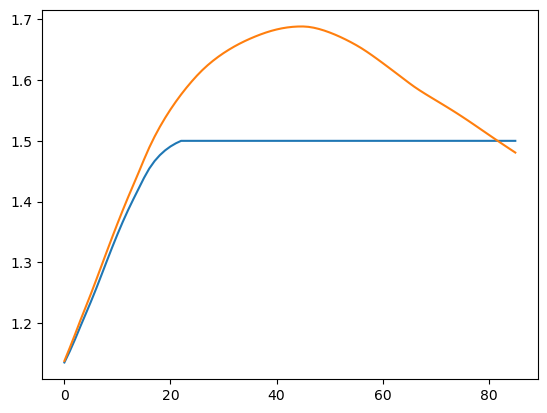

In [33]:
sel_gmt = np.zeros((86,2))
sel_gmt[:, 0] = gmt_ds.loc[:, gmt_ds.columns.str.contains('Ref')].values.mean(axis =1)
sel_gmt[:, 1] = gmt_ds.loc[:, gmt_ds.columns.str.contains('Neg')].values.mean(axis =1)

plt.figure()
plt.plot(sel_gmt)
plt.show()

def compute_exc(gmt):
    gmt_tmp       = (gmt-thrshld).copy()
    gmt_tmp[gmt_tmp < 0] = 0
    gmt_exc       = gmt_tmp.sum()/(86)
    return(gmt_exc)

exc = [regression_df[regression_df.scen_run.str.contains(scen)].loc[:, 'gmt_exc'].median() for scen in ['Ref', 'Neg']]


In [34]:
diff_NEG = (forced_response_df.loc[:, 'Neg'] - forced_response_df.loc[:, 'Ref'])/forced_response_df.loc[:, 'Ref']*100
diff_OS = (forced_response_df.loc[:, 'OS_1.8'] - forced_response_df.loc[:, 'Ref'])/forced_response_df.loc[:, 'Ref']*100

In [35]:
for iso in ['BRA', 'IND', 'NGA', 'SEN']:
    print(iso, diff_NEG.loc[iso], diff_OS.loc[iso])

BRA -7.799451235753617 -13.452234554583924
IND -9.005866118601649 -15.45674503889998
NGA -10.26562596491621 -17.527902652091743
SEN -11.376278535526032 -19.335227655446378


In [36]:
exc[1]-exc[0]

0.10929418604651162

### Plotting 

In [37]:
from matplotlib.colors import LinearSegmentedColormap
cmap_negref    =  LinearSegmentedColormap.from_list("negref", [focus_scenarios_color_dict['Neg'], 'whitesmoke', focus_scenarios_color_dict['Ref']])
cmap_diverging = sns.diverging_palette(20, 220, as_cmap=True)

focus_scenarios     = ['SP', 'Ref', 'Neg',  'GS', 'ssp534-over', 'CurPol']
focus_scenarios_colors =  ['#3b4cc0', '#6a80c2', '#b2925a', '#d6b14c', '#d96b3b', '#a3445a']
focus_scenarios_colors = [
    '#003366', 
    '#4682B4',  # A more muted, relaxed blue
    np.array([0.859, 0.569, 0.339, 1.0]),  # Slightly muted orange
    np.array([0.825, 0.282, 0.278, 1.0]),  # Slightly muted red
    np.array([0.529, 0.175, 0.359, 1.0]),  # Slightly muted dark pink
    np.array([0.294, 0.137, 0.384, 1.0])    # Keeping the last color the same
]

focus_scenarios_color_dict = dict(zip(focus_scenarios, focus_scenarios_colors))

cmap_negref    =  LinearSegmentedColormap.from_list("negref", [focus_scenarios_color_dict['Neg'], 'whitesmoke', focus_scenarios_color_dict['Ref']])
 
focus_countries_colors = ['seagreen',
                          'dodgerblue', 
                          '#00BFFF',
                          np.array([0.92907237, 0.64073303, 0.41912363, 1.0]),
                          np.array([0.87199254, 0.3633634 , 0.35974223, 1.]),
                          np.array([0.60407977, 0.21017746, 0.43913439, 1.]),
                          np.array([0.29408557, 0.13721193, 0.38442775, 1.])
                          ]

focus_countries_colors = ['#2a9d8f', '#4caf50', '#e69f4a', '#d83d52', '#b45b8b', '#8c2d66', '#6a0c9a']
focus_countries_colors = [
    '#2A9D8F',  # Cool Teal
    '#3CB371',  # Medium Green
    # '#8B4513',  # Sad'dle Brown
    'steelblue',
    '#E76F51',  # Coral Red
    '#B45B8B',  # Muted Pink
    '#9B59B6',  # Amethyst Purple
    '#6A0C9A'   # Dark Purple
]

sel_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


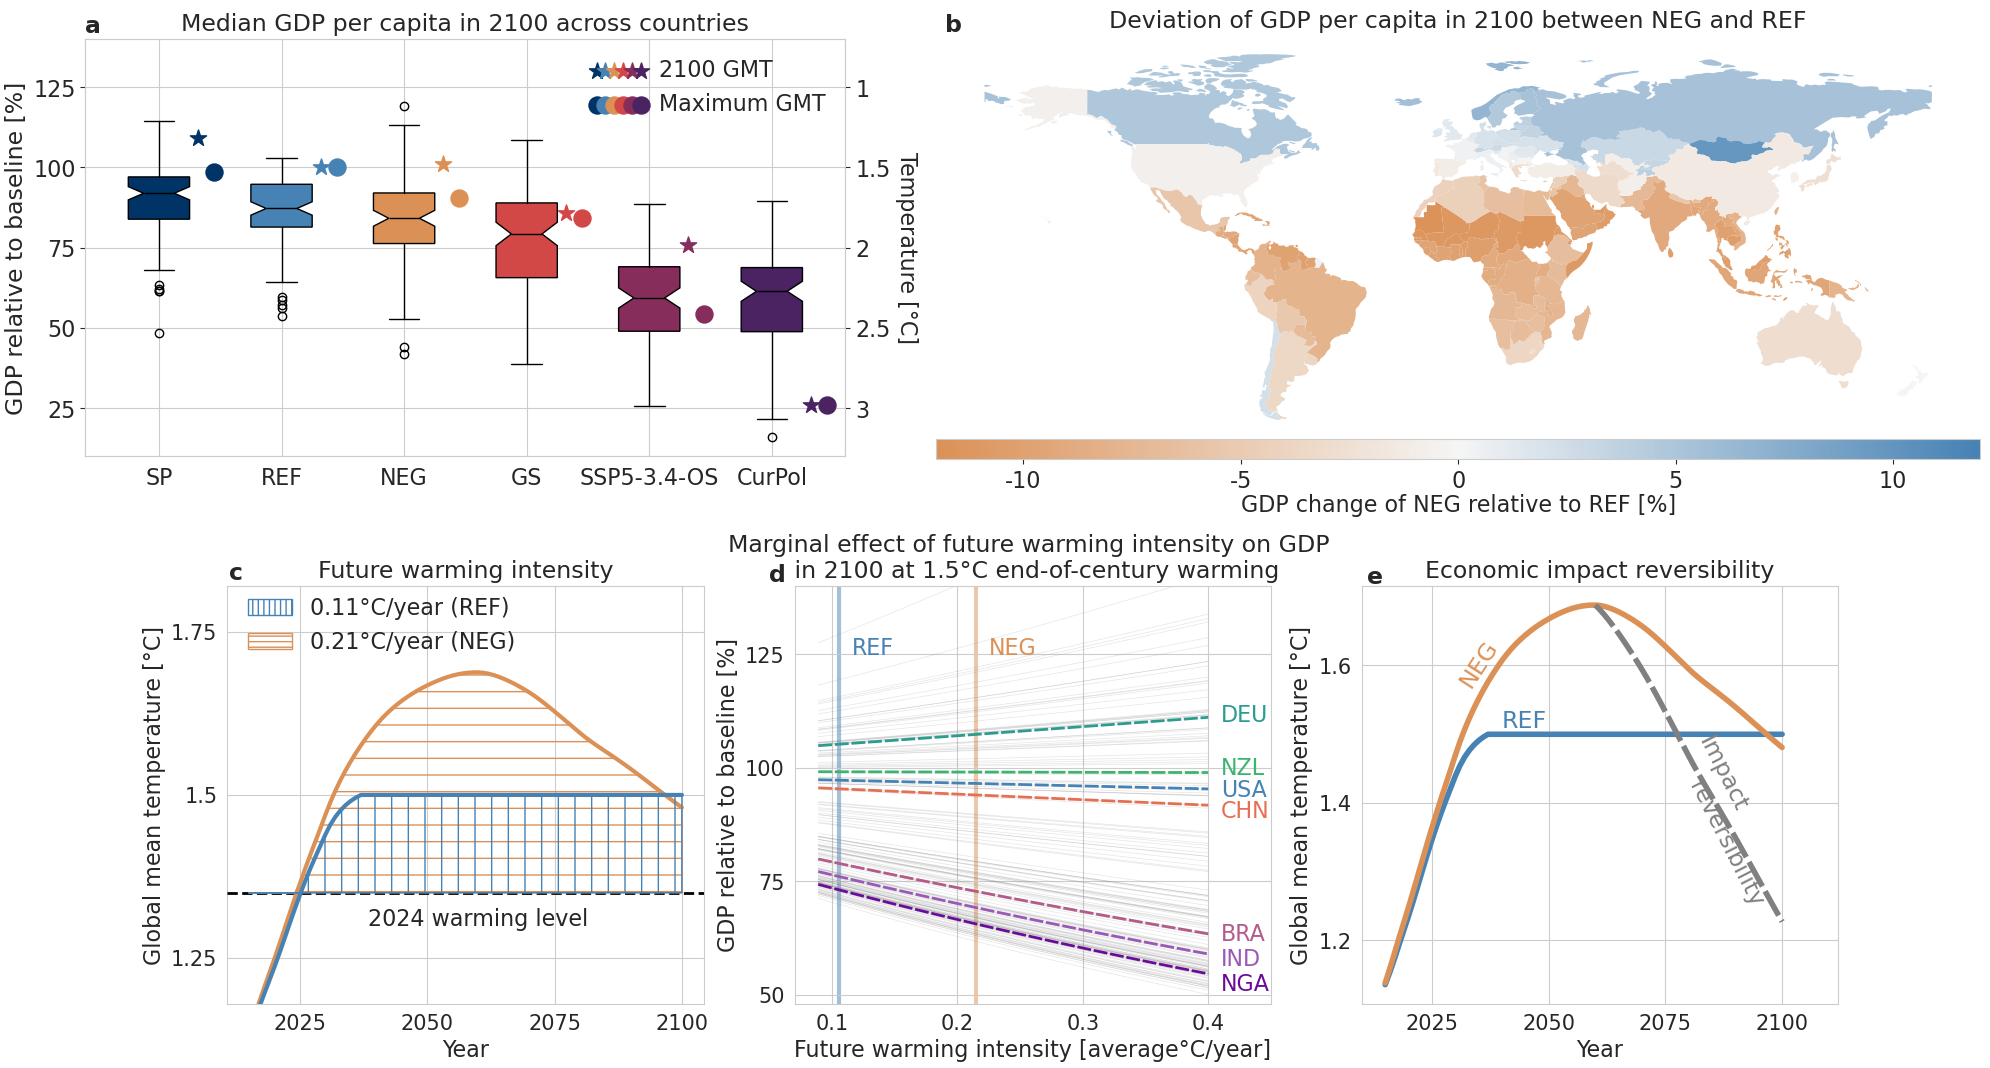

In [38]:
from matplotlib.legend_handler import HandlerTuple
country_offset = [0] + [1] + [0] + [-1] + [1] + [0] + [-1]
impact_offset  = [0] + [0.01] + [-0.002] + [-0.035]*3
ls = (0, (5, 1))
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(20, 12))
        gs  = GridSpec(18, 14, figure=fig)

        ### PANEL A ####
        # - add boxplot:
        ax = fig.add_subplot(gs[1:8,:6])
        bplot = ax.boxplot((boxplot_arr[:, :, 2]).T*100, notch = True, 
                patch_artist = True, zorder = 10)
        for patch, color in zip(bplot['boxes'], focus_scenarios_color_dict.values()):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bplot[element], color='black')
        ax.set_xticks(np.arange(1, 1+cset.n_focus_scenarios),
                      focus_scenarios_labels, 
                        fontsize=labelsize_medium)
        ax.set_yticks([25,50,75,100,125],
                       [25,50,75,100,125],
                        fontsize=labelsize_medium)
        ax.set_ylim(10,140)
        ax.set_xlim(0.4, cset.n_focus_scenarios+0.6)
        ax.set_ylabel(r'GDP relative to baseline [%]', 
                      fontsize=labelsize_large) 
        ax.set_title('Median GDP per capita in 2100 across countries', 
                     fontsize = labelsize_large)   
        ax.text(0.4,142,'a',fontsize = labelsize_large, fontweight = 'bold') 
        # - add a secondary y axis for GMT values
        ax2 = ax.twinx()
        ax2.invert_yaxis()
        ax2.set_ylim(3.3, 0.7)
        ax2.set_yticks([1,1.5,2,2.5,3], 
                       [1,1.5,2,2.5,3],
                       fontsize = labelsize_medium)
        ax2.grid(axis='y', color='white', alpha=0)
        EOC = []
        MAX = []
        for i in range(cset.n_focus_scenarios):
            scatter_eoc = ax2.scatter(i+1+0.32, 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(focus_scenarios[i])].values[-1,:].mean(), 
                        color = focus_scenarios_colors[i], 
                        marker = '*',
                        s = 150,
                        label = ''
                        )
            scatter_max = ax2.scatter(i+1+0.45, 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(focus_scenarios[i])].values[:,:].max(axis = 0).mean(), 
                        color = focus_scenarios_colors[i], 
                        marker = 'o',
                        s = 150,
                        label = ''
                        )
            EOC.append(scatter_eoc)
            MAX.append(scatter_max)
        ax2.set_ylabel('Temperature [°C]', 
                       fontsize = labelsize_medium,
                       rotation = 270,
                       labelpad = 20)
        ax2.legend([(EOC[0], EOC[1], EOC[2], EOC[3], EOC[4], EOC[5]), 
                    (MAX[0], MAX[1], MAX[2], MAX[3], MAX[4], MAX[5])], 
                   ['2100 GMT', 'Maximum GMT'], 
                   handlelength=2,
                   handler_map={tuple: HandlerTuple(ndivide=None)},
                   fontsize = labelsize_medium, 
                   loc = 'upper right', 
                   frameon = False)
        axes.append(ax)
        
        ### PANEL B ####
        # - add worldmap 
        ax = fig.add_subplot(gs[:9,6:])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position = 'bottom', size='5%', pad=0.01)
        
        worldmap = world.plot(column = 'SSP_ref-neg', 
                                ax=ax, 
                                legend=True, 
                                cmap = cmap_negref, 
                                cax=cax, 
                                vmin = -12, 
                                vmax = 12,
                                legend_kwds={'orientation': 'horizontal'})
        
        cax.set_xticks([-10, -5, 0, 5, 10],
                       [-10, -5, 0, 5, 10],
                       fontsize = labelsize_medium)
        cax.set_title('GDP change of NEG relative to REF [%]',
                      fontsize = labelsize_medium,
                      y=-3)

        ax.set_axis_off()
        ax.set_title('Deviation of GDP per capita in 2100 between NEG and REF', 
                     fontsize = labelsize_large)
        ax.text(-195, 92, 'b',fontsize = labelsize_large, fontweight = 'bold') 
        axes.append(ax)
        
        ### PANEL C ####
        # - add stylised exceedance metric plot
        ax = fig.add_subplot(gs[9:-2,1:5])
        ax.axhline(thrshld, 
                   color = 'black', 
                   linestyle = '--', 
                   lw = 2,
                   zorder = 10)
        ax.text(2060, 1.3, '2024 warming level', fontsize = labelsize_medium, ha = 'center')
        labels = ['REF', 'NEG']  
        for i, gmt in enumerate(sel_gmt.T):
                ax.plot(np.linspace(2015,2100,86), gmt, color = sel_colors[i], lw = 3, zorder = 15-i)
                gmt_trajectories_adj = gmt.copy()
                gmt_trajectories_adj[gmt_trajectories_adj < thrshld] = thrshld   
                ax.fill_between(gmt_ds.index, np.repeat(thrshld, len(gmt_ds.index)), gmt_trajectories_adj,
                                 color = 'none', edgecolor = sel_colors[i], hatch = ['|', '-'][i], zorder = 15-i) 
                ax.fill_between(gmt_ds.index, 0, 0, color = 'none', edgecolor = sel_colors[i], hatch = ['|||', '---'][i], label = '{0:.2f}'.format(np.round(exc[i],2)) + f'°C/year ({labels[i]})')
        
        ax.legend(ncol = 1, fontsize = labelsize_medium, bbox_to_anchor = (0.001,0.79), frameon = False, loc=  'lower left')
        ax.set_xticks([2025, 2050, 2075, 2100], 
                      [2025, 2050, 2075, 2100], 
                      fontsize = labelsize_small
                      )
        ax.set_xlabel('Year', fontsize = labelsize_medium)
        ax.set_yticks([1.25, 1.5, 1.75],
                      [1.25, 1.5, 1.75],
                      fontsize = labelsize_small
                      )
        ax.set_ylim(1.18, 1.82)
        ax.set_ylabel('Global mean temperature [°C]', fontsize = labelsize_medium)
        ax.set_title('Future warming intensity', fontsize = labelsize_large)
        ax.text(2011, 1.83, 'c', fontsize = labelsize_large, fontweight = 'bold') 
        axes.append(ax)
        
        ### PANEL D ####
        # - add marginal effects plot
        ax = fig.add_subplot(gs[9:-2,5:9])
        ax.plot(marginal_effects_all.index[8:37], 
                 (np.exp(marginal_effects_all.values[8:37]))*100, 
                 color = 'grey', 
                 alpha = .2, 
                 lw = 0.5)
        ax.axvline(regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].median(), zorder = 0, color = focus_scenarios_color_dict['Ref'], alpha = .5, lw  = 3)
        ax.text(regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].median()+0.01,125,'REF', ha = 'left', fontsize = labelsize_medium, color = focus_scenarios_color_dict['Ref'])
        ax.axvline(regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].median(), zorder = 0, color = focus_scenarios_color_dict['Neg'], alpha = .5, lw = 3)
        ax.text(regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].median()+0.01,125,'NEG', ha = 'left', fontsize = labelsize_medium, color = focus_scenarios_color_dict['Neg'])
        for i, country in enumerate(focus_countries):
            line, = plt.plot(marginal_effects_focus.index[8:37], 
                     (np.exp(marginal_effects_focus).loc[:, country].values[8:37])*100, 
                     color = focus_countries_colors[i], 
                     lw = 2, 
                     label = focus_countries_names[i],
                     linestyle = ls)
            ax.text(0.41, 
                    ((np.exp(marginal_effects_focus).loc[:, country].values)*100)[38]+country_offset[i], 
                    focus_countries[i], 
                    fontsize  = labelsize_medium,
                    color = focus_countries_colors[i],
                    verticalalignment='center')
            
        ax.set_xlim([0.07, 0.45])
        ax.set_xticks([0.1,0.2,0.3,0.4],
                [0.1,0.2,0.3,0.4],
                fontsize = labelsize_small)
        ax.set_yticks([50,75,100,125],
                 [50,75,100,125],
                fontsize = labelsize_small)
        ax.set_xlabel('Future warming intensity [average°C/year]',
                fontsize = labelsize_medium)
        ax.set_ylabel('GDP relative to baseline [%]',
                fontsize = labelsize_medium)
        ax.set_title('Marginal effect of future warming intensity on GDP \n in 2100 at 1.5°C end-of-century warming', fontsize = labelsize_large)   
        ax.set_ylim(48, 140)
        ax.text(0.05, 141, 'd', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)

        ### PANEL E ####
        # - add GMT vs ECON reversibility
        ax = fig.add_subplot(gs[9:-2,9:-1])
        ax.plot(np.linspace(2015,2100,86), gmt_ds.loc[:, gmt_ds.columns.str.contains('Ref')].mean(axis =1).values, color = focus_scenarios_color_dict['Ref'], linewidth = 4)
        ax.plot(np.linspace(2015,2100,86), gmt_ds.loc[:, gmt_ds.columns.str.contains('Neg')].mean(axis =1).values, color = focus_scenarios_color_dict['Neg'], linewidth = 4)
        
        country = focus_countries[-1]
        i_country = len(focus_countries)-1

        plt.plot(np.linspace(2015,2100,86)[45:], 
                country_trajectory_df.loc[:, country].values[45:], 
                color = 'grey', 
                linewidth = 4,
                linestyle = ls)
        
        ax.tick_params(labelsize = 13)
        ax.set_xticks([2025, 2050, 2075, 2100], 
                      [2025, 2050, 2075, 2100], 
                      fontsize = labelsize_small
                      )
        ax.set_yticks([1.2,1.4,1.6], 
                      [1.2,1.4,1.6], 
                      fontsize = labelsize_small
                      )
        ax.text(2040, 1.51, 'REF', color = focus_scenarios_color_dict['Ref'], fontsize = labelsize_large)
        ax.text(2030, 1.57, 'NEG', color = focus_scenarios_color_dict['Neg'], fontsize = labelsize_large, rotation = 57)
        ax.text(2081, 1.39, 'Impact', color = 'grey', fontsize = labelsize_large, rotation = 297)
        ax.text(2079, 1.25, 'reversibility', color = 'grey', fontsize = labelsize_large, rotation = 297)
        ax.set_xlabel('Year', fontsize = labelsize_medium)
        ax.set_ylabel('Global mean temperature [°C]', fontsize = labelsize_medium)
        ax.set_title('Economic impact reversibility', fontsize = labelsize_large)
        ax.set_xlim(2010, 2112)
        ax.text(2011, 1.72, 'e', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)

        # fig.tight_layout(rect=[0, 0.03, 1, 0.9])
        fig.tight_layout(h_pad=0.5)
        plt.savefig(cset.path_GRAPHICS / '002_results.pdf', dpi = 600)